<a href="https://colab.research.google.com/github/NeKonnnn/PetProject-price-real-estate-in-St.-Petersburg/blob/main/notebooks/catboost/2211_pet_proj_property_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepaer

Вызовем необходимые библиотеки, скопируем репозиторий и откроем спарсинный файл 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, mean_absolute_percentage_error

from sklearn.preprocessing import OneHotEncoder

try:
    from catboost import CatBoostRegressor, CatBoostClassifier, Pool, cv
except Exception:
    !pip install catboost
    from catboost import CatBoostRegressor, CatBoostClassifier, Pool, cv

try:
    import optuna
except Exception:
    ! pip install optuna
    import optuna

try:
    import phik
except Exception:
    !pip install phik
    import phik

try:
    import shap
except Exception:
    !pip install shap
    import shap

pd.set_option("display.max_columns", None)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 5.0 MB/s 
     |████████████████████████████████| 210 kB 57.5 MB/s 
     |████████████████████████████████| 81 kB 9.7 MB/s 
     |████████████████████████████████| 78 kB 8.7 MB/s 
     |████████████████████████████████| 50 kB 6.0 MB/s 
     |████████████████████████████████| 147 kB 48.2 MB/s 
     |████████████████████████████████| 112 kB 51.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=27c1d7738fec27818e499d2fb5c5f0f68a0369c279f5ad347df196fea74699f6
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip
  Attempting uninstall: importlib-metadata
    Found 

In [2]:
! git clone https://github.com/NeKonnnn/PetProject-price-real-estate-in-St.-Petersburg

Cloning into 'PetProject-price-real-estate-in-St.-Petersburg'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 131 (delta 67), reused 64 (delta 27), pack-reused 0
Receiving objects: 100% (131/131), 28.10 MiB | 5.36 MiB/s, done.
Resolving deltas: 100% (67/67), done.
Checking out files: 100% (21/21), done.


In [3]:
df = pd.read_csv('/content/PetProject-price-real-estate-in-St.-Petersburg/parser/avito.csv')

# Explore

Выведем первые 5 строк датафрейма и общую информацию о нем.

In [4]:
df.head()

,id,Цена,Адрес,Ближайшее_метро,Дата_публикации,Количество_комнат,Общая_площадь,Жилая_площадь,Этаж,Балкон_или_лоджия,Тип_комнат,Высота_потолков,Санузел,Окна,Ремонт,Мебель,Тёплый_пол,Отделка,Техника,Способ_продажи,Вид_сделки,Тип_дома,Год_постройки,Этажей_в_доме,Пассажирский_лифт,Парковка,В_доме,Двор,Грузовой_лифт,Название_новостройки,Корпус_строение,Официальный_застройщик,Тип_участия,Срок_сдачи,Ссылка,Координаты,ВМО,Район
0,105724302,9800000,"Санкт-Петербург, Пушкинский р-н, пос. Шушары, ...",NaN,17.10.2022 в 10:16,3,73 м²,NaN,1 из 5,балкон,изолированные,NaN,раздельный,"во двор, на улицу, на солнечную сторону",косметический,NaN,NaN,NaN,NaN,свободная,NaN,кирпичный,2012.0,5.0,NaN,NaN,NaN,детская площадка,NaN,NaN,NaN,NaN,NaN,NaN,https://avito.ru//sankt-peterburg/kvartiry/3-k...,"59.737926, 30.461476",Шушары,Пушкинский
1,110963888,24000000,"Санкт-Петербург, наб. реки Фонтанки, 28",Гостиный двор11–15 мин.Невский проспект11–15 м...,17.10.2022 в 01:22,3,85 м²,NaN,3 из 5,NaN,изолированные,NaN,совмещенный,"во двор, на солнечную сторону",дизайнерский,NaN,NaN,NaN,NaN,свободная,NaN,кирпичный,NaN,5.0,NaN,открытая во дворе,NaN,закрытая территория,NaN,NaN,NaN,NaN,NaN,NaN,https://avito.ru//sankt-peterburg/kvartiry/3-k...,"59.939086, 30.343213",Литейный округ,Центральный
2,128257189,12500000,"Санкт-Петербург, Камышовая ул., 3к1",Комендантский проспект6–10 мин.Старая деревняо...,22.10.2022 в 10:29,2,55 м²,NaN,8 из 12,лоджия,изолированные,2.6 м,раздельный,на улицу,требует ремонта,кухня,NaN,NaN,NaN,альтернативная,NaN,панельный,1992.0,12.0,2,открытая во дворе,мусоропровод,NaN,нет,NaN,NaN,NaN,NaN,NaN,https://avito.ru//sankt-peterburg/kvartiry/2-k...,"60.005504, 30.254046",округ Озеро Долгое,Приморский
3,139963851,14200000,"Санкт-Петербург, ул. Беринга, 1",Приморскаяот 31 мин.Василеостровскаяот 31 мин.,21.10.2022 в 16:53,1,50 м²,32 м²,17 из 17,балкон,NaN,3.4 м,совмещенный,NaN,требует ремонта,NaN,NaN,NaN,NaN,альтернативная,NaN,монолитный,2009.0,17.0,1,"подземная, за шлагбаумом во дворе",консьерж,"закрытая территория, детская площадка",1,NaN,NaN,NaN,NaN,NaN,https://avito.ru//sankt-peterburg/kvartiry/1-k...,"59.935831, 30.249087",округ Гавань,Василеостровский
4,204005328,5500000,"Санкт-Петербург, Пулковская ул., 8к2",Звёздная6–10 мин.Купчино21–30 мин.Московская21...,16.10.2022 в 03:52,студия,26 м²,14 м²,9 из 25,балкон,NaN,2.7 м,совмещенный,"во двор, на солнечную сторону",косметический,"кухня, хранение одежды, спальные места",NaN,NaN,"холодильник, стиральная машина",свободная,возможна ипотека,монолитный,2008.0,25.0,NaN,открытая во дворе,мусоропровод,"детская площадка, спортивная площадка",NaN,NaN,NaN,NaN,NaN,NaN,https://avito.ru//sankt-peterburg/kvartiry/kva...,"59.838028, 30.352169",округ Звёздное,Московский


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20235 entries, 0 to 20234
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      20235 non-null  int64  
 1   Цена                    20235 non-null  int64  
 2   Адрес                   20231 non-null  object 
 3   Ближайшее_метро         18219 non-null  object 
 4   Дата_публикации         20235 non-null  object 
 5   Количество_комнат       20222 non-null  object 
 6   Общая_площадь           20222 non-null  object 
 7   Жилая_площадь           17389 non-null  object 
 8   Этаж                    20222 non-null  object 
 9   Балкон_или_лоджия       13758 non-null  object 
 10  Тип_комнат              9767 non-null   object 
 11  Высота_потолков         10107 non-null  object 
 12  Санузел                 15669 non-null  object 
 13  Окна                    13277 non-null  object 
 14  Ремонт                  12817 non-null

In [6]:
df.duplicated().sum()

0

Несмотря на то, что в датафрейме отсутствуют явные дубликаты, в нем могут быть и неявные, которые отличаются `id`, `временем публикации`, `ценой`.
Для анализа таких пропусков сначала посмотрим на процент уникальных значений в столбце `Адрес` 

In [7]:
df['Адрес'].nunique() / len(df)

0.36258957252285645

Более 63% объектов имеют повторяющиеся значения в адресе.
Другими словами, в среднем, каждый адрес упоминается в датафрейме 3 раза. 

Тем не менее, рассмотрение дубликатов только по одному признаку представляется нецелесообразным. 
Для повышения вероятности нахождения дубликатов рассмотрим их наличие в 3х столбцах - `Адрес`, `Общая_площадь`, `Этаж`. 

In [8]:
df[['Адрес', 'Общая_площадь', 'Этаж']].duplicated().sum() / len(df)

0.033110946380034596

Чуть более 3% данных попадают под указанный критерий, что может расцениваться как правдоподоный результат. 

## Features

Признаков очень много и в них есть пропуски.
Так как отсутсвует их описание, нужно рассмотреть каждый детально.
Для этого заполним пропуски на `no_info` и выведем уникальные значения в каждом столбце.

Выполнение указанных действий позволит разработать дальнейший план анализа.


In [9]:
df = df.fillna('no_info')

In [10]:
df['Балкон_или_лоджия'].unique()

array(['балкон', 'no_info', 'лоджия', 'балкон, лоджия'], dtype=object)

Видно, что `балкон, лоджия` - лишний признак. 
Надо ввести обработку, формирующую признаки по каждому значению - аналог One Hot Encoding.

In [11]:
df['В_доме'].unique()

array(['no_info', 'мусоропровод', 'консьерж', 'мусоропровод, газ', 'газ',
       'консьерж, мусоропровод', 'консьерж, газ',
       'консьерж, мусоропровод, газ'], dtype=object)

Аналогичный вывод про признаки

In [12]:
df['Вид_сделки'].unique()

array(['no_info', 'возможна ипотека', 'возможна ипотека, аукцион',
       'аукцион', 'продажа доли', 'возможна ипотека, продажа доли',
       'возможна ипотека, продажа доли, аукцион'], dtype=object)

Аналогичный вывод про признаки

In [13]:
df['Год_постройки'].unique()

array([2012.0, 'no_info', 1992.0, 2009.0, 2008.0, 1969.0, 2020.0, 1912.0,
       1953.0, 1968.0, 2006.0, 1982.0, 1973.0, 1960.0, 2013.0, 1910.0,
       2003.0, 2001.0, 1966.0, 1971.0, 2017.0, 2014.0, 2019.0, 2015.0,
       1965.0, 2007.0, 2018.0, 1917.0, 1986.0, 2004.0, 2021.0, 1995.0,
       2016.0, 1967.0, 1974.0, 1906.0, 1800.0, 1984.0, 2010.0, 2000.0,
       1888.0, 1989.0, 1958.0, 1962.0, 1987.0, 1860.0, 1963.0, 1949.0,
       2022.0, 1853.0, 1939.0, 1903.0, 1872.0, 1979.0, 1996.0, 1956.0,
       1972.0, 1904.0, 1998.0, 1890.0, 1955.0, 1916.0, 1935.0, 2005.0,
       1898.0, 1952.0, 1879.0, 1870.0, 1957.0, 1961.0, 1978.0, 1970.0,
       2011.0, 1977.0, 1828.0, 1999.0, 1803.0, 1954.0, 1838.0, 12.0,
       1981.0, 1983.0, 1884.0, 1988.0, 1985.0, 1959.0, 1975.0, 1933.0,
       1883.0, 1990.0, 1852.0, 1976.0, 1859.0, 1864.0, 1964.0, 1929.0,
       1881.0, 1880.0, 1836.0, 1791.0, 1980.0, 1905.0, 1940.0, 1911.0,
       2002.0, 1837.0, 1997.0, 1901.0, 1835.0, 1991.0, 1878.0, 1909.0,
     

Есть ошибки ввода.
Нужно вводить обработку.

In [14]:
df['Грузовой_лифт'].unique()

array(['no_info', 'нет', '1', '2', '4', '3'], dtype=object)

Ок

In [15]:
df['Двор'].unique()

array(['детская площадка', 'закрытая территория', 'no_info',
       'закрытая территория, детская площадка',
       'детская площадка, спортивная площадка',
       'закрытая территория, детская площадка, спортивная площадка',
       'спортивная площадка', 'закрытая территория, спортивная площадка'],
      dtype=object)

Требуется разделение признаков

In [16]:
df['Количество_комнат'].unique()

array(['3', '2', '1', 'студия', '4', '5', '7', '6', 'no_info',
       'свободная планировка', '10 и больше', '8', '9'], dtype=object)

Нужна обработка в части выделения `свободная планировка` и `no_info` в отдлеьные признаки, а в текущем признаке оставить только числовые значения.

In [17]:
df['Название_новостройки'].unique()
df['Официальный_застройщик'].unique()
df['Корпус_строение'].unique()

array(['no_info', 'Корпус 2 (Квартал 75А)', 'Корпус 1 (1 очередь)',
       'Корпус 27', 'Корпус 1', 'Корпус 2 (1 очередь)',
       '3 этап, корпус 3', 'Корпус 2 (уч. 1689, 2 этап)',
       'Корпус 3 (уч. 1689, 2 этап)',
       'Корпус 229.1-229.2 (Дом 21-22, 19 квартал)', 'Корпус 6',
       'Корпус 3.2.2', 'Корпус 3.1.2', 'Корпус Мистраль', 'Дом 24',
       'Дом 2', 'Дом 21', 'Корпус 6 (д. 9, литер В)',
       'Дом 1 (секции 1.1-1.10) (участок 1)', 'Корпус 3',
       'Корпус 327.1 (эт. 4-5, уч. 15, кв-л 26)', 'Дом 22',
       'Дом 5 (Корпус 13.2.2)', 'Корпус 1 (уч. 1689, 1 этап)',
       '3 этап, корпус 4', 'Корпус 11.4 (Дом 6)',
       'Корпус 5 (уч. 1687, 1 этап)', 'Корпус 13.1.1 (Дом 1)',
       'Дом 17 (Корпус 19.3)', 'Корпус 14.2',
       'Корпус 253.1 (эт. 28-30, уч. 132)', 'Корпус 14.4', 'Корпус 2',
       '1 очередь', 'Корпус 7.1.1', 'Корпус 2.3.1', 'Корпус 2.1.1',
       'Дом 8 (Корпус 13.2.5)', 'Блок Б3',
       'Корпус 326.2 (эт. 1-3, уч. 15, кв-л 26)', 'Корпус 1.4 (Дом 17)'

Бесполезные принзнаки, которые по смыслу дублируют адрес.

In [18]:
df['Мебель'].unique()

array(['no_info', 'кухня', 'кухня, хранение одежды, спальные места',
       'кухня, спальные места', 'хранение одежды',
       'кухня, хранение одежды', 'спальные места',
       'хранение одежды, спальные места'], dtype=object)

Требуется разделение признаков

In [19]:
df['Окна'].unique()

array(['во двор, на улицу, на солнечную сторону',
       'во двор, на солнечную сторону', 'на улицу', 'no_info',
       'во двор, на улицу', 'во двор', 'на улицу, на солнечную сторону',
       'на солнечную сторону'], dtype=object)

Требуется разделение признаков

In [20]:
df['Отделка'].unique()

array(['no_info', 'чистовая', 'предчистовая', 'без отделки'], dtype=object)

Простой категориальный признак.

In [21]:
df['Парковка'].unique()

array(['no_info', 'открытая во дворе',
       'подземная, за шлагбаумом во дворе', 'подземная',
       'за шлагбаумом во дворе',
       'подземная, открытая во дворе, за шлагбаумом во дворе',
       'открытая во дворе, за шлагбаумом во дворе',
       'подземная, наземная многоуровневая',
       'подземная, наземная многоуровневая, открытая во дворе',
       'наземная многоуровневая, открытая во дворе',
       'подземная, открытая во дворе',
       'наземная многоуровневая, за шлагбаумом во дворе',
       'наземная многоуровневая',
       'подземная, наземная многоуровневая, открытая во дворе, за шлагбаумом во дворе',
       'подземная, наземная многоуровневая, за шлагбаумом во дворе',
       'наземная многоуровневая, открытая во дворе, за шлагбаумом во дворе'],
      dtype=object)

Требуется разделение признаков

In [22]:
df['Пассажирский_лифт'].unique()

array(['no_info', '2', '1', '3', 'нет', '4'], dtype=object)

Нужна обработка в части выделения `no_info` в отдлеьный признак, а в текущем признаке оставить только числовые значения.

In [23]:
df['Ремонт'].unique()

array(['косметический', 'дизайнерский', 'требует ремонта', 'no_info',
       'евро'], dtype=object)

Простой категориальный признак.

In [24]:
df['Санузел'].unique()

array(['раздельный', 'совмещенный', 'no_info', 'совмещенный, раздельный'],
      dtype=object)

Простой категориальный признак.

In [25]:
df['Способ_продажи'].unique()

array(['свободная', 'альтернативная', 'no_info', 'переуступка',
       'договор ЖСК', 'договор долевого участия'], dtype=object)

Простой категориальный признак.

In [26]:
df['Срок_сдачи'].unique()

array(['no_info', 'сдан', '4 кв. 2022 года', '1 кв. 2023 года',
       '3 кв. 2023 года', '4 кв. 2023 года', '4 кв. 2025 года',
       '3 кв. 2022 года, сдача не подтверждена', '2 кв. 2023 года',
       '4 кв. 2024 года', '3 кв. 2024 года', '2 кв. 2024 года',
       '2 кв. 2025 года', '1 кв. 2025 года',
       '2 кв. 2022 года, сдача не подтверждена',
       '3 кв. 2019 года, сдача не подтверждена', '1 кв. 2024 года',
       '3 кв. 2025 года', '2 кв. 2026 года', '3 кв. 2026 года',
       '4 кв. 2026 года'], dtype=object)

Потребуется обработка и расчет сроков до окончания строительства.

In [27]:
df['Техника'].unique()

array(['no_info', 'холодильник, стиральная машина',
       'кондиционер, холодильник, стиральная машина',
       'холодильник, стиральная машина, посудомоечная машина, водонагреватель',
       'холодильник, стиральная машина, посудомоечная машина',
       'холодильник, стиральная машина, водонагреватель', 'холодильник',
       'посудомоечная машина', 'посудомоечная машина, водонагреватель',
       'кондиционер, холодильник, стиральная машина, посудомоечная машина, водонагреватель',
       'стиральная машина',
       'кондиционер, холодильник, посудомоечная машина, водонагреватель',
       'холодильник, водонагреватель', 'водонагреватель',
       'холодильник, посудомоечная машина', 'кондиционер',
       'стиральная машина, посудомоечная машина',
       'кондиционер, холодильник, стиральная машина, посудомоечная машина',
       'стиральная машина, посудомоечная машина, водонагреватель',
       'кондиционер, водонагреватель',
       'кондиционер, холодильник, стиральная машина, водонагре

Требуется разделение признаков

In [28]:
df['Тип_дома'].unique()

array(['кирпичный', 'панельный', 'монолитный', 'монолитно-кирпичный',
       'блочный', 'no_info', 'деревянный'], dtype=object)

Простой категориальный признак.

In [29]:
df['Тип_комнат'].unique()

array(['изолированные', 'no_info', 'изолированные, смежные', 'смежные'],
      dtype=object)

Требуется разделение признаков

In [30]:
df['Тип_участия'].unique()

array(['no_info', 'другое', 'ДДУ по ФЗ 214', 'ЖСК'], dtype=object)

Простой категориальный признак.

In [31]:
df['Тёплый_пол'].unique()

array(['no_info', 'есть'], dtype=object)

Простой категориальный признак.

In [32]:
df['Цена'].describe()

count    2.023500e+04
mean     1.350531e+07
std      8.066536e+07
min      7.689000e+03
25%      6.186144e+06
50%      8.580000e+06
75%      1.383198e+07
max      9.000000e+09
Name: Цена, dtype: float64

Большие значения - выбросы.
Маленькие значения - сдача в аренду?

In [33]:
df['Этаж'].unique()

array(['1 из 5', '3 из 5', '8 из 12', '17 из 17', '9 из 25', '1 из 9',
       '9 из 20', '9 из 24', '1 из 4', '18 из 19', '5 из 7', '5 из 6',
       '2 из 5', '1 из 8', '12 из 16', '10 из 18', '3 из 6', '6 из 14',
       '5 из 9', '6 из 12', '7 из 12', '5 из 5', '10 из 12', '12 из 17',
       '2 из 11', '25 из 25', '6 из 25', '2 из 16', '10 из 13', '6 из 9',
       '15 из 25', '11 из 24', '11 из 25', '13 из 22', '1 из 10',
       '19 из 23', '18 из 25', '21 из 25', '2 из 7', '4 из 5', '2 из 9',
       '5 из 8', '7 из 23', '14 из 23', '3 из 9', '14 из 20', '12 из 24',
       '3 из 10', '3 из 18', '19 из 26', '9 из 12', '20 из 25',
       '15 из 18', '2 из 23', '2 из 4', '23 из 26', '10 из 21', '8 из 18',
       '4 из 24', '4 из 10', '7 из 8', '8 из 23', '3 из 4', '16 из 23',
       '2 из 13', '12 из 13', '7 из 9', '12 из 12', '19 из 25',
       '13 из 13', '2 из 20', '4 из 12', '8 из 25', '1 из 25', '6 из 13',
       '14 из 24', '17 из 28', '9 из 16', '1 из 20', '20 из 23', '6 из 8',
  

Требуется обработка и выделение этажа

In [34]:
df['Этажей_в_доме'].unique()

array([5.0, 12.0, 17.0, 25.0, 9.0, 20.0, 24.0, 4.0, 19.0, 7.0, 6.0, 8.0,
       16.0, 18.0, 14.0, 11.0, 13.0, 22.0, 10.0, 23.0, 26.0, 21.0, 28.0,
       15.0, 3.0, 27.0, 29.0, 2.0, 1.0, 35.0, 'no_info', 36.0, 32.0, 33.0,
       34.0, 75.0, 40.0], dtype=object)

Дублирует Этаж


In [35]:
df['ВМО'].unique()

array(['Шушары', 'Литейный округ', 'округ Озеро Долгое', 'округ Гавань',
       'округ Звёздное', 'округ Волковское', 'Южно-Приморский округ',
       'округ Коломяги', 'округ Смольнинское', 'Владимирский округ',
       'округ Московская застава', 'округ Ульянка',
       'округ Красненькая речка', 'округ Морской', 'округ Сергиевское',
       'округ Сампсониевское', 'Невский округ', 'округ Пороховые',
       'округ Пискарёвка', 'округ № 65', 'округ Светлановское',
       'округ Юнтолово', 'округ Ланское', 'округ Малая Охта',
       'Народный округ', 'округ № 15', 'округ Правобережный',
       'округ Комендантский аэродром', 'округ Семёновский', 'Колпино',
       'округ Гражданка', 'округ Аптекарский остров', 'Финляндский округ',
       'Парголово', 'округ Сосновая поляна', 'округ Пулковский меридиан',
       'округ Лиговка-Ямская', 'no_info', 'Нарвский округ',
       'округ Полюстрово', 'округ Оккервиль', 'Петровский округ',
       'округ Чкаловское', 'округ Константиновское',
       'Ал

In [36]:
df[df['ВМО'] == 'Москва']

,id,Цена,Адрес,Ближайшее_метро,Дата_публикации,Количество_комнат,Общая_площадь,Жилая_площадь,Этаж,Балкон_или_лоджия,Тип_комнат,Высота_потолков,Санузел,Окна,Ремонт,Мебель,Тёплый_пол,Отделка,Техника,Способ_продажи,Вид_сделки,Тип_дома,Год_постройки,Этажей_в_доме,Пассажирский_лифт,Парковка,В_доме,Двор,Грузовой_лифт,Название_новостройки,Корпус_строение,Официальный_застройщик,Тип_участия,Срок_сдачи,Ссылка,Координаты,ВМО,Район
2230,2213502128,10900000,"б-р Измайловский, уч. 3",Балтийская11–15 мин.Фрунзенская11–15 мин.Моско...,17.10.2022 в 00:23,1,40 м²,11 м²,5 из 17,лоджия,no_info,2.8 м,совмещенный,во двор,no_info,no_info,no_info,без отделки,no_info,переуступка,no_info,монолитно-кирпичный,no_info,17.0,1,открытая во дворе,no_info,закрытая территория,1,Квартал «Галактика»,"Корпус 9.1, стр. 3 (уч. 3)",ООО «Специализированный Застройщик «Эталон Гал...,ДДУ по ФЗ 214,1 кв. 2023 года,https://avito.ru//sankt-peterburg/kvartiry/1-k...,"55.797731, 37.78394",Москва,no_info
3479,2295152046,17491100,"б-р Измайловский, уч. 3",Балтийская11–15 мин.Фрунзенская11–15 мин.Моско...,12.10.2022 в 20:28,2,67.8 м²,30.8 м²,5 из 18,no_info,изолированные,no_info,no_info,no_info,no_info,no_info,no_info,без отделки,no_info,no_info,no_info,монолитный,no_info,18.0,no_info,no_info,no_info,no_info,no_info,Квартал «Галактика»,"Корпус 9.1, стр. 2 (уч. 3)",ООО «Специализированный Застройщик «Эталон Гал...,ДДУ по ФЗ 214,1 кв. 2023 года,https://avito.ru//sankt-peterburg/kvartiry/2-k...,"55.797731, 37.78394",Москва,no_info
3483,2295241030,10611999,"б-р Измайловский, уч. 3",Балтийская21–30 мин.Фрунзенская21–30 мин.Моско...,24.10.2022 в 11:49,1,42.2 м²,15.6 м²,4 из 18,no_info,no_info,no_info,no_info,no_info,no_info,no_info,no_info,без отделки,no_info,no_info,no_info,монолитный,no_info,18.0,no_info,no_info,no_info,no_info,no_info,Квартал «Галактика»,"Корпус 9.1, стр. 2 (уч. 3)",ООО «Специализированный Застройщик «Эталон Гал...,ДДУ по ФЗ 214,1 кв. 2023 года,https://avito.ru//sankt-peterburg/kvartiry/1-k...,"55.797731, 37.78394",Москва,no_info
3502,2295610453,13105518,"б-р Измайловский, уч. 3",Балтийская11–15 мин.Фрунзенская11–15 мин.Моско...,17.10.2022 в 08:29,1,45.6 м²,13.7 м²,5 из 18,no_info,no_info,no_info,no_info,no_info,no_info,no_info,no_info,без отделки,no_info,no_info,no_info,монолитный,no_info,18.0,no_info,no_info,no_info,no_info,no_info,Квартал «Галактика»,"Корпус 9.1, стр. 2 (уч. 3)",ООО «Специализированный Застройщик «Эталон Гал...,ДДУ по ФЗ 214,1 кв. 2023 года,https://avito.ru//sankt-peterburg/kvartiry/1-k...,"55.797731, 37.78394",Москва,no_info
3510,2295736115,10365677,"б-р Измайловский, уч. 3",Балтийская11–15 мин.Фрунзенская11–15 мин.Моско...,12.10.2022 в 05:12,студия,32.5 м²,17.4 м²,11 из 18,no_info,no_info,no_info,no_info,no_info,no_info,no_info,no_info,без отделки,no_info,no_info,no_info,монолитный,no_info,18.0,no_info,no_info,no_info,no_info,no_info,Квартал «Галактика»,"Корпус 9.1, стр. 2 (уч. 3)",ООО «Специализированный Застройщик «Эталон Гал...,ДДУ по ФЗ 214,1 кв. 2023 года,https://avito.ru//sankt-peterburg/kvartiry/kva...,"55.797731, 37.78394",Москва,no_info
5451,2390881763,17250004,"б-р Измайловский, уч. 3",Балтийская21–30 мин.Фрунзенская21–30 мин.Моско...,22.10.2022 в 02:10,2,58 м²,26 м²,14 из 18,no_info,изолированные,no_info,no_info,no_info,no_info,no_info,no_info,без отделки,no_info,no_info,no_info,монолитный,no_info,18.0,no_info,no_info,no_info,no_info,no_info,Квартал «Галактика»,"Корпус 9.1, стр. 2 (уч. 3)",ООО «Специализированный Застройщик «Эталон Гал...,ДДУ по ФЗ 214,1 кв. 2023 года,https://avito.ru//sankt-peterburg/kvartiry/2-k...,"55.797731, 37.78394",Москва,no_info
5453,2390916903,10542391,"б-р Измайловский, уч. 3",Балтийская11–15 мин.Фрунзенская11–15 мин.Моско...,13.10.2022 в 06:09,студия,33.9 м²,19.7 м²,12 из 18,no_info,no_info,no_info,no_info,no_info,no_info,no_info,no_info,без отделки,no_info,no_info,no_info,монолитный,no_info,18.0,no_info,no_info,no_info,no_info,no_info,Квартал «Галактика»,"Корпус 9.1, стр. 2 (уч. 3)",ООО «Специализирован

## Conclusions

**Жирным** выделены добавки после первого запуска модели

1. Бесполезные для моделирования признаки: id, Адрес, Ссылка, Официальный_застройщик, Название_новостройки, Корпус_строение - Сразу удаляем.

1. Так же удаляем объекты с одинаковыми значениями в Адрес, Общая_площадь, Этаж

1. **Метро исключаем совсем.**  

1. Координаты необходимо разбить на два столбца - широта и долгота. Добавить фильтр только координат, характерных для ЛО и отбросить выбросы. Добавить расчет дистанции до **каждого** метро (**ввести расчет**) и дистанции до центра (при необходимости). 

1. Признаки нужно оптимизировать с точки зрения их состава, исключить повторяющиеся **и ввести свертку суммированием**. Балкон_или_лоджия, Вид_сделки, В_доме, Двор, Мебель, Окна, Парковка, Санузел, Техника, Тип_комнат

1. В дате надо обрезать время. Используя Срок_сдачи рассчитать время до окончания строительства в месяцах. Используя Год_постройки (исправить маленькие значения) определить возраст постройки.

1. Категориальные признаки: Грузовой_лифт (нет = 0), Количество_комнат (студию заменить на 0), Ремонт, Отделка, Пассажирский_лифт, Способ_продажи, Тип_дома, Тип_участия, Тёплый_пол (заменить на 0/1), 

1. Непрерывные признаки: Общая_площадь, Жилая_площадь, Высота_потолков  - отбросить размерность. Пропуски заменить на 0.

1. Этаж - разбить на 2 столбца и сравнить с Этажей_в_доме

1. Целевой признак - Цена. Нужно проанализировать большие и малые значения и отсетить, например, по 2% с каждой стороны.


# Repair data

Сперва удалим неинформативные столбцы и дубликаты.

In [37]:
df = df.drop(['id', 'Ссылка', 'Официальный_застройщик', 
              'Название_новостройки', 'Корпус_строение', 'Ближайшее_метро'], axis=1)

df = df.drop_duplicates(['Адрес', 'Общая_площадь', 'Этаж'])

## Обработка координат

Разделим координаты объекта на разные столбцы.
Затем выведем общую информацию о распределении величин в них.

In [38]:
df[['Широта_Объекта', 'Долгота_Объекта']] = df['Координаты'].str.split(', ',expand=True).astype('float')

In [39]:
df[['Широта_Объекта', 'Долгота_Объекта']].describe()

,Широта_Объекта,Долгота_Объекта
count,19565.000000,19565.000000
mean,59.675410,30.485540
std,2.044360,3.272827
min,38.552623,-4.719892
25%,59.852538,30.251297
50%,59.931927,30.326360
75%,60.000654,30.406679
max,60.262019,137.986851


Видно, что в данных есть выбросы, не характерные для координат СПб.
Ограничив последние диапазоном по широте от 58,7 до 61 град и по долготе от 28,5 до 33,5, введем фильтр.

In [40]:
df[(df['Широта_Объекта'] > 61) | (df['Широта_Объекта'] < 58.7) | 
   (df['Долгота_Объекта'] > 33.5) | (df['Долгота_Объекта'] < 28.5)]['Цена'].count()

348

In [41]:
df = df.drop(df[(df['Широта_Объекта'] > 61) | (df['Широта_Объекта'] < 58.7) | 
   (df['Долгота_Объекта'] > 33.5) | (df['Долгота_Объекта'] < 28.5)].index)

Исключим более ненужные столбцы.

In [42]:
df = df.drop(['Координаты', 'Адрес'], axis=1)

## Добавление расстояния до метро

Прочитаем файл с коордиинатами метро и вызовем таблицу

In [43]:
metro_coordinates = pd.read_csv('/content/PetProject-price-real-estate-in-St.-Petersburg/parser/metro.csv')

In [44]:
metro_coordinates

,Станция,Координаты
0,Девяткино,"60.050182, 30.443045"
1,Гражданский проспект,"60.034969, 30.418224"
2,Академическая,"60.012806, 30.396044"
3,Политехническая,"60.008942, 30.370907"
4,Площадь Мужества,"59.999828, 30.366159"
...,...,...
67,Бухарестская,"59.883769, 30.368932"
68,Международная,"59.870203, 30.379289"
69,Дунайская,"59.839889, 30.410667"
70,Проспект Славы,"59.856704, 30.395402"


Требуется разделение координат по разным столбцам

In [45]:
metro_coordinates['Станция'] = metro_coordinates['Станция'].str.lower()
metro_coordinates[['Широта', 'Долгота']] = metro_coordinates['Координаты'].str.split(', ',expand=True).astype('float')
metro_coordinates = metro_coordinates.drop('Координаты', axis=1)

metro_coordinates.head()

,Станция,Широта,Долгота
0,девяткино,60.050182,30.443045
1,гражданский проспект,60.034969,30.418224
2,академическая,60.012806,30.396044
3,политехническая,60.008942,30.370907
4,площадь мужества,59.999828,30.366159


In [46]:
metro_coordinates[metro_coordinates['Станция'] == 'шушары']

,Станция,Широта,Долгота
71,шушары,59.819973,30.432718


Успех!
Следующим шагом создадим функцию для расчета расстояния объекта до каждого метро 

In [47]:
def distinator(row, latitiude_fin, longitude_fin):
    '''
    Расчет расстояния в км
    '''
    return round(np.sqrt((row['Широта_Объекта'] - latitiude_fin)**2 + 
                        (row['Долгота_Объекта'] - longitude_fin)**2) * 111.13, 3)

Для корректной работы функции требуется сбросить индексы

In [48]:
df = df.reset_index(drop=True)

stations_names = ['расстояние_до_' + "_".join(x.split()) for x in metro_coordinates['Станция']]
stations_distance = pd.DataFrame(columns=stations_names)
for i in tqdm(range(len(stations_names))):
    stations_distance[stations_names[i]] = df.apply(distinator, 
                                args=(metro_coordinates['Широта'][i], 
                                        metro_coordinates['Долгота'][i]), 
                                axis=1
                                )

df['closed_metro_distination'] = stations_distance.min(axis=1)

In [49]:
stations_names = [
    'комендантский проспект',
    'крестовский остров',
    'шушары',
    'парнас',
    'купчино',
    'улица дыбенко',
    'девяткино',
    'проспект ветеранов',
]
for i in tqdm(stations_names):
    df[i + '_dist'] = df.apply(distinator, 
                            args=(metro_coordinates[metro_coordinates['Станция'] == i]['Широта'], 
                                    metro_coordinates[metro_coordinates['Станция'] == i]['Долгота']),
                                axis=1
                                )

  0%|          | 0/8 [00:00<?, ?it/s]

In [50]:
df.head()

,Цена,Дата_публикации,Количество_комнат,Общая_площадь,Жилая_площадь,Этаж,Балкон_или_лоджия,Тип_комнат,Высота_потолков,Санузел,Окна,Ремонт,Мебель,Тёплый_пол,Отделка,Техника,Способ_продажи,Вид_сделки,Тип_дома,Год_постройки,Этажей_в_доме,Пассажирский_лифт,Парковка,В_доме,Двор,Грузовой_лифт,Тип_участия,Срок_сдачи,ВМО,Район,Широта_Объекта,Долгота_Объекта,комендантский проспект_dist,крестовский остров_dist,шушары_dist,парнас_dist,купчино_dist,улица дыбенко_dist,девяткино_dist,проспект ветеранов_dist
0,9800000,17.10.2022 в 10:16,3,73 м²,no_info,1 из 5,балкон,изолированные,no_info,раздельный,"во двор, на улицу, на солнечную сторону",косметический,no_info,no_info,no_info,no_info,свободная,no_info,кирпичный,2012.0,5.0,no_info,no_info,no_info,детская площадка,no_info,no_info,no_info,Шушары,Пушкинский,59.737926,30.461476,37.586,34.347,9.662,39.223,13.966,18.991,34.761,26.140
1,24000000,17.10.2022 в 01:22,3,85 м²,no_info,3 из 5,no_info,изолированные,no_info,совмещенный,"во двор, на солнечную сторону",дизайнерский,no_info,no_info,no_info,no_info,свободная,no_info,кирпичный,no_info,5.0,no_info,открытая во дворе,no_info,закрытая территория,no_info,no_info,no_info,Литейный округ,Центральный,59.939086,30.343213,12.163,9.996,16.558,14.252,12.672,15.962,16.599,14.903
2,12500000,22.10.2022 в 10:29,2,55 м²,no_info,8 из 12,лоджия,изолированные,2.6 м,раздельный,на улицу,требует ремонта,кухня,no_info,no_info,no_info,альтернативная,no_info,панельный,1992.0,12.0,2,открытая во дворе,мусоропровод,no_info,нет,no_info,no_info,округ Озеро Долгое,Приморский,60.005504,30.254046,0.617,3.791,28.624,11.195,23.751,27.712,21.582,18.162
3,14200000,21.10.2022 в 16:53,1,50 м²,32 м²,17 из 17,балкон,no_info,3.4 м,совмещенный,no_info,требует ремонта,no_info,no_info,no_info,no_info,альтернативная,no_info,монолитный,2009.0,17.0,1,"подземная, за шлагбаумом во дворе",консьерж,"закрытая территория, детская площадка",1,no_info,no_info,округ Гавань,Василеостровский,59.935831,30.249087,8.156,4.162,24.129,17.354,18.354,26.220,25.022,10.417
4,5500000,16.10.2022 в 03:52,студия,26 м²,14 м²,9 из 25,балкон,no_info,2.7 м,совмещенный,"во двор, на солнечную сторону",косметический,"кухня, хранение одежды, спальные места",no_info,no_info,"холодильник, стиральная машина",свободная,возможна ипотека,монолитный,2008.0,25.0,no_info,открытая во дворе,мусоропровод,"детская площадка, спортивная площадка",no_info,no_info,no_info,округ Звёздное,Московский,59.838028,30.352169,21.616,18.091,9.174,25.526,2.771,16.488,25.649,11.298


Обработка успешна

## Анализ цены объектов

Для дальнейшего анализа данных полезно взглянуть на распределения цены объектов.

In [51]:
df['Цена'].describe()

count    1.921700e+04
mean     1.361423e+07
std      8.272910e+07
min      7.689000e+03
25%      6.190000e+06
50%      8.592000e+06
75%      1.392807e+07
max      9.000000e+09
Name: Цена, dtype: float64

Виден очень большой разброс в данных, что может быть как свидетельством мошеннической деятельности, так и ошибками пользователей при заполнении информации в объявлениях.
Построим гистограмму значений между 25 и 75 перцентилями.

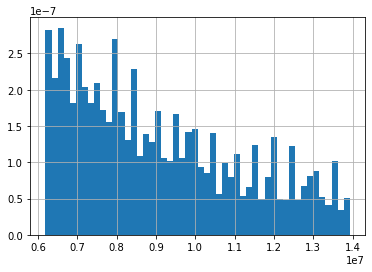

In [52]:
df[(df['Цена'] >= np.percentile(df['Цена'], 25)) & 
    (df['Цена'] <= np.percentile(df['Цена'], 75))]['Цена'].hist(bins=50, density=True)
plt.show()

Гистограмма имеет очень рваный характер.
Это обусловлено желанием пользователей объявить более "красивую" (округленную) цену.
Такое распределение отрицательно скажется на точность работы моделей машинного обуения, так как абсолютно разные объекты обладают одинаковой стоимостью.

Нивелирование такого распределения можно достич введя в рассмотрение стоимость квадратного метра.
С этой целью сперва необходимо обработать соответствующие столбцы датафрейма.

In [53]:
for i in ['Общая_площадь', 'Жилая_площадь', 'Высота_потолков']:
    df[i] = df[i].replace({'no_info': 0})
    df.loc[df[i] != 0, i] = df[i].str.split(' ', expand=True)[0]
    df[i] = df[i].astype('float')

Так как общая площадь стоит в знаменателе при расчете ее стоимости, необходимо исключить объекты с нулевым значением указанного параметра. 

In [54]:
len(df[df['Общая_площадь'] == 0]) / len(df)

0.0005203725867721289

Таких значений менее 0,1%. Можем смело отбрасывать.

In [55]:
df = df.drop(df[df['Общая_площадь'] == 0].index)

df['Цена_кв_м'] = df['Цена'] / df['Общая_площадь']

df['Цена_кв_м'].describe()

count    1.920700e+04
mean     2.402381e+05
std      2.147889e+06
min      1.297847e+02
25%      1.641444e+05
50%      1.981651e+05
75%      2.509515e+05
max      2.571429e+08
Name: Цена_кв_м, dtype: float64

Здесь так же присутсвуют выбросы.
Для принятия окончательного решения (какую цену использовать) построим вместе графики цены в целом и цены за кв.м. 

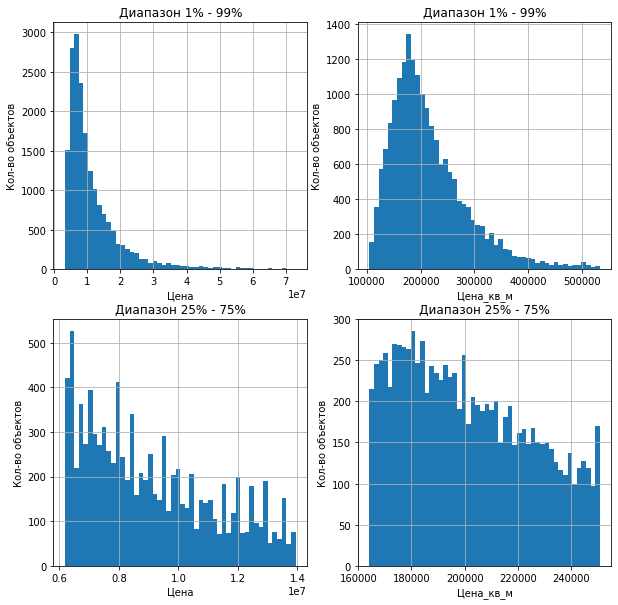

In [56]:
width = 2
height = 2
features = ['Цена', 'Цена_кв_м']
low_perc = [1, 25]
high_perc = [99, 75]

_, axs = plt.subplots(width, height, figsize=(10, 10))
for j in range(width):
    for i in range(height):
        df[(df[features[i]] >= np.percentile(df[features[i]], low_perc[j])) & 
           (df[features[i]] <= np.percentile(df[features[i]], high_perc[j]))
           ][features[i]].hist(bins=50, ax=axs[j, i]) 
        axs[j, i].set_title(f'Диапазон {low_perc[j]}% - {high_perc[j]}%')
        axs[j, i].set_xlabel(features[i])
        axs[j, i].set_ylabel('Кол-во объектов')

plt.show()

Из графиков видно, что распределение цены за кв. метр более сглаженно относительно общей цены и менее подвержено сильным выбросам.
В этой связи в качестве целевого признака для модели будем использовать именно указанный параметр.

Исключим из датафрейма объекты, выходящие из диапазона от 1 до 99 перцентиля по цене кв.м

In [57]:
df = df.drop(df[(df['Цена_кв_м'] < np.percentile(df['Цена_кв_м'], 1)) | 
                (df['Цена_кв_м'] > np.percentile(df['Цена_кв_м'], 99))].index)

In [58]:
df = df.drop('Жилая_площадь', axis=1)

Добавим категории цены квадратного метра. Это может повысить качество моделирования.

In [59]:
cost_categories = [0, 
                   150e3, 
#                   180e3, 
                   200e3, 
#                   225e3, 
                   250e3, 
                   300e3, 
                   float('inf')]

cost_categories_labels = [0, 1, 2, 3, 4]#, 5, 6]

df['Цена_кв_м_кат'] = pd.cut(df['Цена_кв_м'], cost_categories, labels=cost_categories_labels)

df.groupby(by='Цена_кв_м_кат')['Общая_площадь'].agg({'count', 'mean'})

,count,mean
Цена_кв_м_кат,,
0,2935,54.279898
1,6750,49.090563
2,4454,49.429704
3,2468,54.907496
4,2214,70.722584


## Добавление расстояния до центра

Построим карту объявлений с цветовой подсветкой по районам и измением размера точки от цены кв.м

In [60]:
def map_objects(feature, hue, df=df):
    plt.figure(figsize=(10, 10))
    sns.scatterplot(data=df, 
                    x='Долгота_Объекта', 
                    y='Широта_Объекта', 
                    hue=hue, 
                    size=feature,
                    sizes=(10,200))

    sns.scatterplot(data=df[df[feature] == df[feature].max()], 
                    x='Долгота_Объекта', 
                    y='Широта_Объекта', 
                    marker='*', 
                    s=200, 
                    color='r',
                    palette='flag',
                    label=f'Макс {feature}')
    sns.scatterplot(data=df[df[feature] == df[feature].min()], 
                    x='Долгота_Объекта', 
                    y='Широта_Объекта', 
                    marker='*', 
                    s=200, 
                    color='g',
                    palette='flag',
                    label=f'Мин {feature}')
    plt.show()

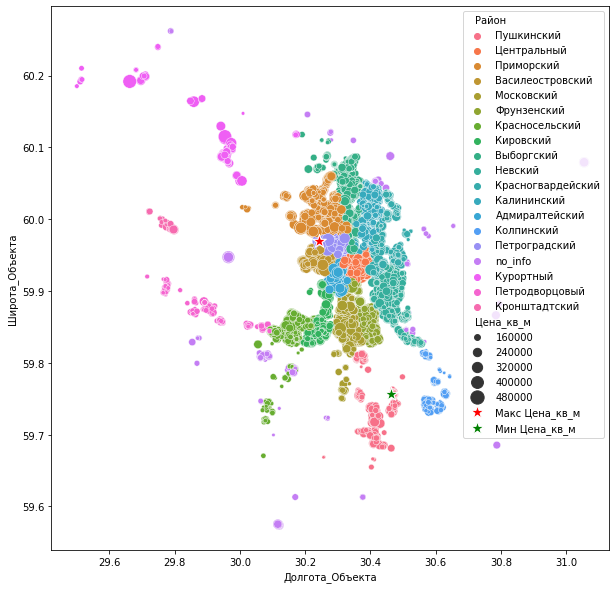

In [61]:
map_objects('Цена_кв_м', 'Район')

Построим еще сводник по средней стоимости площади в каждом районе.

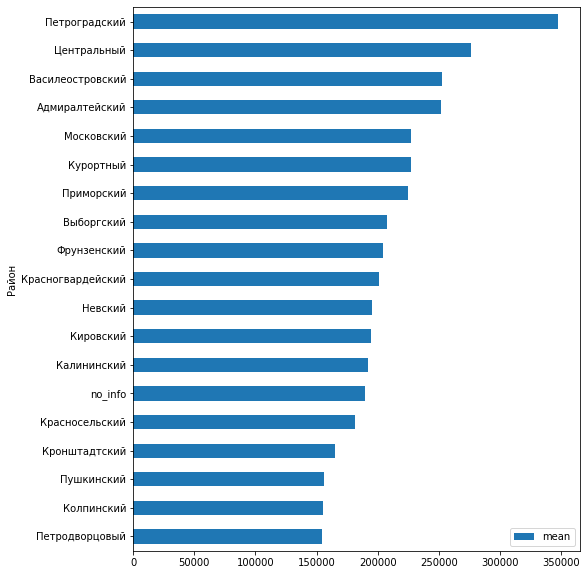

In [62]:
df.groupby(by='Район')['Цена_кв_м'].agg({'mean'}).sort_values(by='mean').plot(figsize=(8,10), kind="barh")
plt.show()

Самая дорогая площадь находится в Петроградском районе, а самая дешевая - в Пушкинском.
В качестве центра можно использовать координаты метро Крестовский остров.
Однако расчет расстояния объекта до указанной станции выполнен в предыдущем разделе.

В этой связи, дополнительный расчет до центра вводить не будем.

Введение координат до каждой станции метро позволяет исключить из рассмотрения признаки Района и ВМО

In [63]:
df = df.drop(['ВМО', 'Район'], axis=1)

df.head()

,Цена,Дата_публикации,Количество_комнат,Общая_площадь,Этаж,Балкон_или_лоджия,Тип_комнат,Высота_потолков,Санузел,Окна,Ремонт,Мебель,Тёплый_пол,Отделка,Техника,Способ_продажи,Вид_сделки,Тип_дома,Год_постройки,Этажей_в_доме,Пассажирский_лифт,Парковка,В_доме,Двор,Грузовой_лифт,Тип_участия,Срок_сдачи,Широта_Объекта,Долгота_Объекта,комендантский проспект_dist,крестовский остров_dist,шушары_dist,парнас_dist,купчино_dist,улица дыбенко_dist,девяткино_dist,проспект ветеранов_dist,Цена_кв_м,Цена_кв_м_кат
0,9800000,17.10.2022 в 10:16,3,73.0,1 из 5,балкон,изолированные,0.0,раздельный,"во двор, на улицу, на солнечную сторону",косметический,no_info,no_info,no_info,no_info,свободная,no_info,кирпичный,2012.0,5.0,no_info,no_info,no_info,детская площадка,no_info,no_info,no_info,59.737926,30.461476,37.586,34.347,9.662,39.223,13.966,18.991,34.761,26.140,134246.575342,0
1,24000000,17.10.2022 в 01:22,3,85.0,3 из 5,no_info,изолированные,0.0,совмещенный,"во двор, на солнечную сторону",дизайнерский,no_info,no_info,no_info,no_info,свободная,no_info,кирпичный,no_info,5.0,no_info,открытая во дворе,no_info,закрытая территория,no_info,no_info,no_info,59.939086,30.343213,12.163,9.996,16.558,14.252,12.672,15.962,16.599,14.903,282352.941176,3
2,12500000,22.10.2022 в 10:29,2,55.0,8 из 12,лоджия,изолированные,2.6,раздельный,на улицу,требует ремонта,кухня,no_info,no_info,no_info,альтернативная,no_info,панельный,1992.0,12.0,2,открытая во дворе,мусоропровод,no_info,нет,no_info,no_info,60.005504,30.254046,0.617,3.791,28.624,11.195,23.751,27.712,21.582,18.162,227272.727273,2
3,14200000,21.10.2022 в 16:53,1,50.0,17 из 17,балкон,no_info,3.4,совмещенный,no_info,требует ремонта,no_info,no_info,no_info,no_info,альтернативная,no_info,монолитный,2009.0,17.0,1,"подземная, за шлагбаумом во дворе",консьерж,"закрытая территория, детская площадка",1,no_info,no_info,59.935831,30.249087,8.156,4.162,24.129,17.354,18.354,26.220,25.022,10.417,284000.000000,3
4,5500000,16.10.2022 в 03:52,студия,26.0,9 из 25,балкон,no_info,2.7,совмещенный,"во двор, на солнечную сторону",косметический,"кухня, хранение одежды, спальные места",no_info,no_info,"холодильник, стиральная машина",свободная,возможна ипотека,монолитный,2008.0,25.0,no_info,открытая во дворе,мусоропровод,"детская площадка, спортивная площадка",no_info,no_info,no_info,59.838028,30.352169,21.616,18.091,9.174,25.526,2.771,16.488,25.649,11.298,211538.461538,2


## Обработка признаков с большим перечнем значений 

В некоторых признаках встречаются повторяющиеся значения.
Введем их кодирование разделением на новые признаки со значением 0/1, с последующим суммирование в один признак.

In [64]:
def my_ohe(faeture_name: str):
    '''
    Find the longest feature in column with FEATURE_NAME 
    and separate it in the list FEATURES_SEP.
    Following create the TEMP table with columns named 
    by each faeture in FEATURES_SEP and in all rows compare FEATURE_NAME 
    with each faeture in FEATURES_SEP, then mark 1 in case they match and 0 opposite
    Return convolusion by rows of the TEMP
    '''
    features = df[faeture_name].unique().tolist()
    num_of_sym = [len(x) for x in features]
    features_sep = features[num_of_sym.index(max(num_of_sym))].split(', ') 
    temp = pd.DataFrame()

    def mask(row, feature:list):
        if feature in row[faeture_name].split(', '):
            return 1
        return 0
        
    for feature in features_sep:
        temp[faeture_name + '_' + feature] = df.apply(mask, args=[feature], axis=1)

    df[faeture_name + '_свертка'] = temp.sum(axis=1)

In [65]:
large_features = ['Балкон_или_лоджия', 'Вид_сделки', 'В_доме', 'Двор', 
                  'Мебель', 'Окна', 'Парковка', 'Санузел', 'Техника', 
                  'Тип_комнат']
                  
for i in large_features:
    my_ohe(i)
    
df = df.drop(large_features, axis=1)
df.head()

,Цена,Дата_публикации,Количество_комнат,Общая_площадь,Этаж,Высота_потолков,Ремонт,Тёплый_пол,Отделка,Способ_продажи,Тип_дома,Год_постройки,Этажей_в_доме,Пассажирский_лифт,Грузовой_лифт,Тип_участия,Срок_сдачи,Широта_Объекта,Долгота_Объекта,комендантский проспект_dist,крестовский остров_dist,шушары_dist,парнас_dist,купчино_dist,улица дыбенко_dist,девяткино_dist,проспект ветеранов_dist,Цена_кв_м,Цена_кв_м_кат,Балкон_или_лоджия_свертка,Вид_сделки_свертка,В_доме_свертка,Двор_свертка,Мебель_свертка,Окна_свертка,Парковка_свертка,Санузел_свертка,Техника_свертка,Тип_комнат_свертка
0,9800000,17.10.2022 в 10:16,3,73.0,1 из 5,0.0,косметический,no_info,no_info,свободная,кирпичный,2012.0,5.0,no_info,no_info,no_info,no_info,59.737926,30.461476,37.586,34.347,9.662,39.223,13.966,18.991,34.761,26.140,134246.575342,0,1,0,0,1,0,3,0,1,0,1
1,24000000,17.10.2022 в 01:22,3,85.0,3 из 5,0.0,дизайнерский,no_info,no_info,свободная,кирпичный,no_info,5.0,no_info,no_info,no_info,no_info,59.939086,30.343213,12.163,9.996,16.558,14.252,12.672,15.962,16.599,14.903,282352.941176,3,0,0,0,1,0,2,1,1,0,1
2,12500000,22.10.2022 в 10:29,2,55.0,8 из 12,2.6,требует ремонта,no_info,no_info,альтернативная,панельный,1992.0,12.0,2,нет,no_info,no_info,60.005504,30.254046,0.617,3.791,28.624,11.195,23.751,27.712,21.582,18.162,227272.727273,2,1,0,1,0,1,1,1,1,0,1
3,14200000,21.10.2022 в 16:53,1,50.0,17 из 17,3.4,требует ремонта,no_info,no_info,альтернативная,монолитный,2009.0,17.0,1,1,no_info,no_info,59.935831,30.249087,8.156,4.162,24.129,17.354,18.354,26.220,25.022,10.417,284000.000000,3,1,0,1,2,0,0,2,1,0,0
4,5500000,16.10.2022 в 03:52,студия,26.0,9 из 25,2.7,косметический,no_info,no_info,свободная,монолитный,2008.0,25.0,no_info,no_info,no_info,no_info,59.838028,30.352169,21.616,18.091,9.174,25.526,2.771,16.488,25.649,11.298,211538.461538,2,1,1,1,2,3,2,1,1,2,0


## Обработка временных признаков

В столбце с датой публикации использованы разные способы записи дат.
Исправим переименованием, исключим время и сохраним месяц публикации (поможет в дальнейшем при пополнении базы объявлений и выделении сезонности).

In [66]:
date_rename = {
    'января':'.01.2022',
    'февраля':'.02.2022',
    'марта':'.03.2022',
    'апреля':'.04.2022',
    'мая':'.05.2022',
    'июня':'.06.2022',
    'июля':'.07.2022',
    'августа':'.08.2022',
    'сентября':'.09.2022',
    'октября':'.10.2022',
    'ноября':'.11.2022',
    'декабря':'.12.2022',
}

dates = df['Дата_публикации'].str.split(' в ', expand=True)[0]
dates = dates.str.split(' ', expand=True).replace(date_rename)
dates = dates.fillna('')

df['Дата_публикации'] = dates[0] + dates[1]
df['Дата_публикации'] = pd.to_datetime(df['Дата_публикации'])
df['Месяц_публикации'] = df['Дата_публикации'].dt.month
df.head()

,Цена,Дата_публикации,Количество_комнат,Общая_площадь,Этаж,Высота_потолков,Ремонт,Тёплый_пол,Отделка,Способ_продажи,Тип_дома,Год_постройки,Этажей_в_доме,Пассажирский_лифт,Грузовой_лифт,Тип_участия,Срок_сдачи,Широта_Объекта,Долгота_Объекта,комендантский проспект_dist,крестовский остров_dist,шушары_dist,парнас_dist,купчино_dist,улица дыбенко_dist,девяткино_dist,проспект ветеранов_dist,Цена_кв_м,Цена_кв_м_кат,Балкон_или_лоджия_свертка,Вид_сделки_свертка,В_доме_свертка,Двор_свертка,Мебель_свертка,Окна_свертка,Парковка_свертка,Санузел_свертка,Техника_свертка,Тип_комнат_свертка,Месяц_публикации
0,9800000,2022-10-17,3,73.0,1 из 5,0.0,косметический,no_info,no_info,свободная,кирпичный,2012.0,5.0,no_info,no_info,no_info,no_info,59.737926,30.461476,37.586,34.347,9.662,39.223,13.966,18.991,34.761,26.140,134246.575342,0,1,0,0,1,0,3,0,1,0,1,10
1,24000000,2022-10-17,3,85.0,3 из 5,0.0,дизайнерский,no_info,no_info,свободная,кирпичный,no_info,5.0,no_info,no_info,no_info,no_info,59.939086,30.343213,12.163,9.996,16.558,14.252,12.672,15.962,16.599,14.903,282352.941176,3,0,0,0,1,0,2,1,1,0,1,10
2,12500000,2022-10-22,2,55.0,8 из 12,2.6,требует ремонта,no_info,no_info,альтернативная,панельный,1992.0,12.0,2,нет,no_info,no_info,60.005504,30.254046,0.617,3.791,28.624,11.195,23.751,27.712,21.582,18.162,227272.727273,2,1,0,1,0,1,1,1,1,0,1,10
3,14200000,2022-10-21,1,50.0,17 из 17,3.4,требует ремонта,no_info,no_info,альтернативная,монолитный,2009.0,17.0,1,1,no_info,no_info,59.935831,30.249087,8.156,4.162,24.129,17.354,18.354,26.220,25.022,10.417,284000.000000,3,1,0,1,2,0,0,2,1,0,0,10
4,5500000,2022-10-16,студия,26.0,9 из 25,2.7,косметический,no_info,no_info,свободная,монолитный,2008.0,25.0,no_info,no_info,no_info,no_info,59.838028,30.352169,21.616,18.091,9.174,25.526,2.771,16.488,25.649,11.298,211538.461538,2,1,1,1,2,3,2,1,1,2,0,10


Используя Срок_сдачи и Год_постройки рассчитаем возраст постройки.
Отрицательные значения будут соответствовать неоконченному строительству.

In [67]:
def date_repairer(row):
    current_year = row['Дата_публикации'].year
    if row['Срок_сдачи'] == 'сдан':
        return 0
    if re.search('\d\d\d\d', row['Срок_сдачи']):
        return current_year - int(re.search('\d\d\d\d', row['Срок_сдачи'])[0])
    if type(row['Год_постройки']) == (float):
        if row['Год_постройки'] < 100:
            return current_year - (int(row['Год_постройки']) + 1900)
        if row['Год_постройки'] < 300:
            return current_year - (int(row['Год_постройки']) - 200 + 2000)
        return current_year - int(row['Год_постройки'])
    return 'no_info'

In [68]:
df['Возраст_дома'] = df.apply(date_repairer, axis=1)
t = df[df['Возраст_дома'] != 'no_info']

df = df.drop(t[t['Возраст_дома'] > 300].index, axis=0) #Удалим оставшийся мусор

Исключим ненужные столбцы

In [69]:
df = df.drop(['Год_постройки', 'Срок_сдачи', 'Дата_публикации'], axis=1)

## Категориальные признаки

Сделаем функцию, которая создает новый признак со значениями 0/1, соответствующим значению no_info в исходном признаке.
При этом в исходном заменяются соответствующие значения на 0.

In [70]:
def make_me_continues(feature_name):
    new_feature = feature_name + '_no_info'
    df[new_feature] = 0
    df.loc[df[feature_name] == 'no_info', new_feature] = 1

    df[feature_name] = df[feature_name].replace({
        'no_info': 0,
        'нет': 0,
        'студия': 0, 
        'свободная планировка': 0,
        '10 и больше': 10,
        'есть': 1
        })
    
    df[feature_name] = df[feature_name].astype('int')

In [71]:
features_continues = [
    'Грузовой_лифт', 
    'Пассажирский_лифт', 
    'Возраст_дома', 
    'Количество_комнат', 
    'Тёплый_пол'
    ]

for i in features_continues:
    make_me_continues(i)

In [72]:
df.head()

,Цена,Количество_комнат,Общая_площадь,Этаж,Высота_потолков,Ремонт,Тёплый_пол,Отделка,Способ_продажи,Тип_дома,Этажей_в_доме,Пассажирский_лифт,Грузовой_лифт,Тип_участия,Широта_Объекта,Долгота_Объекта,комендантский проспект_dist,крестовский остров_dist,шушары_dist,парнас_dist,купчино_dist,улица дыбенко_dist,девяткино_dist,проспект ветеранов_dist,Цена_кв_м,Цена_кв_м_кат,Балкон_или_лоджия_свертка,Вид_сделки_свертка,В_доме_свертка,Двор_свертка,Мебель_свертка,Окна_свертка,Парковка_свертка,Санузел_свертка,Техника_свертка,Тип_комнат_свертка,Месяц_публикации,Возраст_дома,Грузовой_лифт_no_info,Пассажирский_лифт_no_info,Возраст_дома_no_info,Количество_комнат_no_info,Тёплый_пол_no_info
0,9800000,3,73.0,1 из 5,0.0,косметический,0,no_info,свободная,кирпичный,5.0,0,0,no_info,59.737926,30.461476,37.586,34.347,9.662,39.223,13.966,18.991,34.761,26.140,134246.575342,0,1,0,0,1,0,3,0,1,0,1,10,10,1,1,0,0,1
1,24000000,3,85.0,3 из 5,0.0,дизайнерский,0,no_info,свободная,кирпичный,5.0,0,0,no_info,59.939086,30.343213,12.163,9.996,16.558,14.252,12.672,15.962,16.599,14.903,282352.941176,3,0,0,0,1,0,2,1,1,0,1,10,0,1,1,1,0,1
2,12500000,2,55.0,8 из 12,2.6,требует ремонта,0,no_info,альтернативная,панельный,12.0,2,0,no_info,60.005504,30.254046,0.617,3.791,28.624,11.195,23.751,27.712,21.582,18.162,227272.727273,2,1,0,1,0,1,1,1,1,0,1,10,30,0,0,0,0,1
3,14200000,1,50.0,17 из 17,3.4,требует ремонта,0,no_info,альтернативная,монолитный,17.0,1,1,no_info,59.935831,30.249087,8.156,4.162,24.129,17.354,18.354,26.220,25.022,10.417,284000.000000,3,1,0,1,2,0,0,2,1,0,0,10,13,0,0,0,0,1
4,5500000,0,26.0,9 из 25,2.7,косметический,0,no_info,свободная,монолитный,25.0,0,0,no_info,59.838028,30.352169,21.616,18.091,9.174,25.526,2.771,16.488,25.649,11.298,211538.461538,2,1,1,1,2,3,2,1,1,2,0,10,14,1,1,0,0,1


## Обработка этажей

In [73]:
df['Этаж'] = df['Этаж'].replace({'no_info': 0})
df.loc[df['Этаж'] != 0, 'Этаж'] = df['Этаж'].str.split(' ', expand=True)[0]
df['Этаж'] = df['Этаж'].astype('int')

In [74]:
df = df.drop('Этажей_в_доме', axis=1)

In [75]:
df.head()

,Цена,Количество_комнат,Общая_площадь,Этаж,Высота_потолков,Ремонт,Тёплый_пол,Отделка,Способ_продажи,Тип_дома,Пассажирский_лифт,Грузовой_лифт,Тип_участия,Широта_Объекта,Долгота_Объекта,комендантский проспект_dist,крестовский остров_dist,шушары_dist,парнас_dist,купчино_dist,улица дыбенко_dist,девяткино_dist,проспект ветеранов_dist,Цена_кв_м,Цена_кв_м_кат,Балкон_или_лоджия_свертка,Вид_сделки_свертка,В_доме_свертка,Двор_свертка,Мебель_свертка,Окна_свертка,Парковка_свертка,Санузел_свертка,Техника_свертка,Тип_комнат_свертка,Месяц_публикации,Возраст_дома,Грузовой_лифт_no_info,Пассажирский_лифт_no_info,Возраст_дома_no_info,Количество_комнат_no_info,Тёплый_пол_no_info
0,9800000,3,73.0,1,0.0,косметический,0,no_info,свободная,кирпичный,0,0,no_info,59.737926,30.461476,37.586,34.347,9.662,39.223,13.966,18.991,34.761,26.140,134246.575342,0,1,0,0,1,0,3,0,1,0,1,10,10,1,1,0,0,1
1,24000000,3,85.0,3,0.0,дизайнерский,0,no_info,свободная,кирпичный,0,0,no_info,59.939086,30.343213,12.163,9.996,16.558,14.252,12.672,15.962,16.599,14.903,282352.941176,3,0,0,0,1,0,2,1,1,0,1,10,0,1,1,1,0,1
2,12500000,2,55.0,8,2.6,требует ремонта,0,no_info,альтернативная,панельный,2,0,no_info,60.005504,30.254046,0.617,3.791,28.624,11.195,23.751,27.712,21.582,18.162,227272.727273,2,1,0,1,0,1,1,1,1,0,1,10,30,0,0,0,0,1
3,14200000,1,50.0,17,3.4,требует ремонта,0,no_info,альтернативная,монолитный,1,1,no_info,59.935831,30.249087,8.156,4.162,24.129,17.354,18.354,26.220,25.022,10.417,284000.000000,3,1,0,1,2,0,0,2,1,0,0,10,13,0,0,0,0,1
4,5500000,0,26.0,9,2.7,косметический,0,no_info,свободная,монолитный,0,0,no_info,59.838028,30.352169,21.616,18.091,9.174,25.526,2.771,16.488,25.649,11.298,211538.461538,2,1,1,1,2,3,2,1,1,2,0,10,14,1,1,0,0,1


## Phik

In [76]:
phik_matrix = df.phik_matrix()

interval columns not set, guessing: ['Цена', 'Количество_комнат', 'Общая_площадь', 'Этаж', 'Высота_потолков', 'Тёплый_пол', 'Пассажирский_лифт', 'Грузовой_лифт', 'Широта_Объекта', 'Долгота_Объекта', 'комендантский проспект_dist', 'крестовский остров_dist', 'шушары_dist', 'парнас_dist', 'купчино_dist', 'улица дыбенко_dist', 'девяткино_dist', 'проспект ветеранов_dist', 'Цена_кв_м', 'Балкон_или_лоджия_свертка', 'Вид_сделки_свертка', 'В_доме_свертка', 'Двор_свертка', 'Мебель_свертка', 'Окна_свертка', 'Парковка_свертка', 'Санузел_свертка', 'Техника_свертка', 'Тип_комнат_свертка', 'Месяц_публикации', 'Возраст_дома', 'Грузовой_лифт_no_info', 'Пассажирский_лифт_no_info', 'Возраст_дома_no_info', 'Количество_комнат_no_info', 'Тёплый_пол_no_info']


Not enough unique value for variable Количество_комнат_no_info for analysis 1. Dropping this column


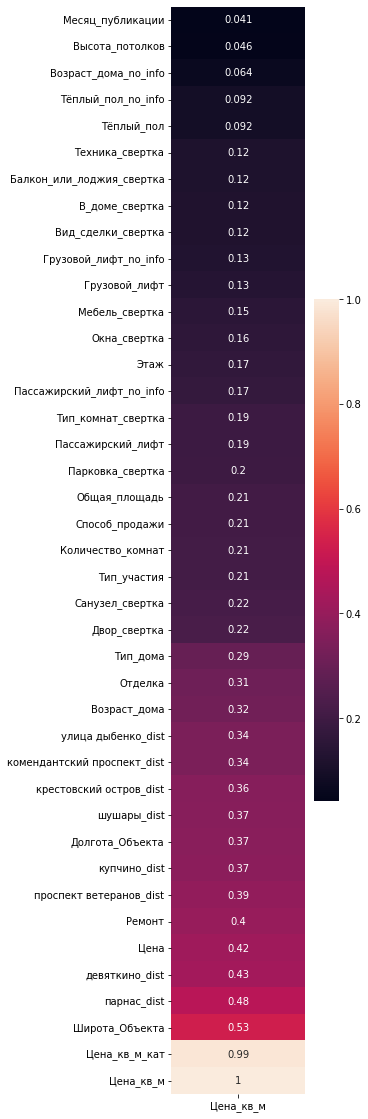

In [77]:
y = ['Цена_кв_м']

plt.figure(figsize=(3, 20))
sns.heatmap(phik_matrix[y].sort_values(by=y), annot=True)
plt.show()

Исключим все признаки с корреляцией меньше 0,1.

In [78]:
X_phik = phik_matrix[phik_matrix['Цена_кв_м'] > 0.1]['Цена_кв_м'].index.tolist()

df = df[X_phik]

Посмотрим на полную матрицу фик

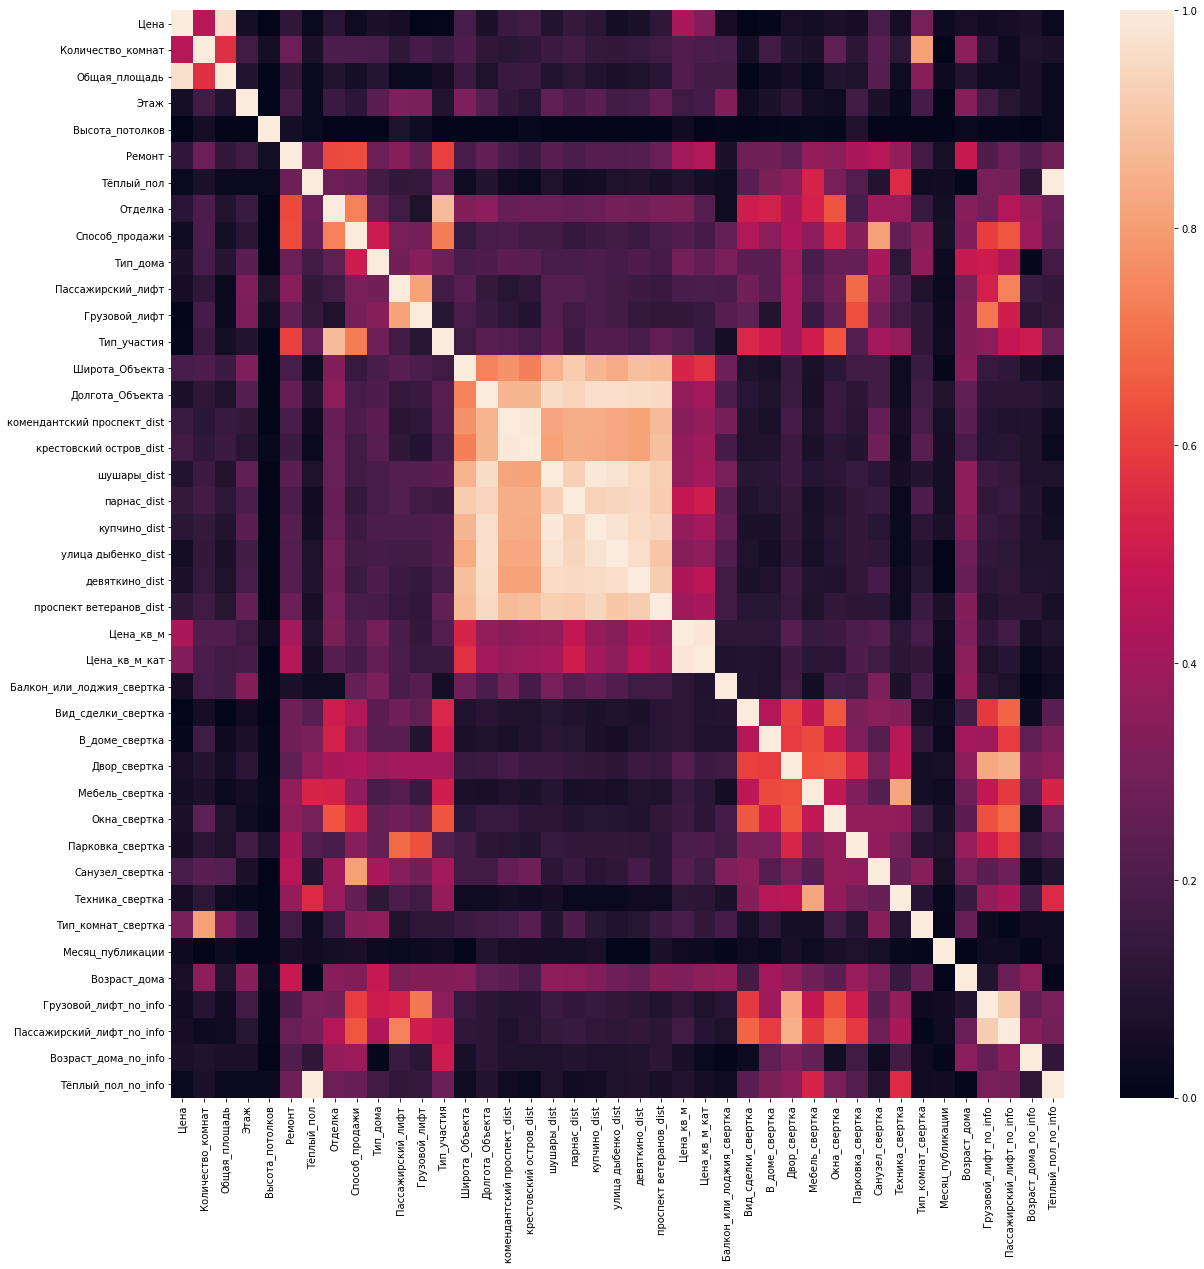

In [79]:
plt.figure(figsize=(20, 20))
sns.heatmap(phik_matrix)
plt.show()

Сильная мультиколлинеарность. Использовать линейные модели нельзя.

# Baseline - Human learning

In [80]:
SEED = 26

In [81]:
train, test = train_test_split(df, test_size=.2, random_state=SEED)

y = ['Цена_кв_м']

square_categories = [0, 30, 40, 50, 60, 70, float('inf')]

train['Общая_площадь_кат'] = pd.cut(train['Общая_площадь'], square_categories)
test['Общая_площадь_кат'] = pd.cut(test['Общая_площадь'], square_categories)

learning_mask = train.groupby(by='Общая_площадь_кат')[y].agg('median').reset_index()

test = test.merge(learning_mask, how='left', on='Общая_площадь_кат', suffixes=('', '_pred'))

mean_absolute_percentage_error(test['Цена_кв_м'], test['Цена_кв_м_pred'])

0.23358830480146905

# Catboost

In [85]:
def ohe_transformer(df, cat_features, encoder, encoder_columns):
    ohe = encoder.transform(df[cat_features])
    ohe = pd.DataFrame(ohe, columns=encoder_columns, index=df.index)
    ohe = df.drop(cat_features, axis=1).join(ohe)#.astype('int')
    return ohe


def ohe(train, test, cat_features):
    encoder = OneHotEncoder(drop="first", sparse=False)
    encoder.fit(train[cat_features])
    encoder_columns = ["_".join(x.split()) for x in encoder.get_feature_names_out()]
    return ohe_transformer(
        train, cat_features, encoder, encoder_columns
    ), ohe_transformer(test, cat_features, encoder, encoder_columns)

## Classifier

In [85]:
train, test = train_test_split(df, test_size=.2, random_state=SEED)

In [86]:
y_cl = ['Цена_кв_м_кат']

cat_features_cb = [
    'Ремонт', 
    'Отделка',
    'Способ_продажи',
    'Тип_дома', 
    'Тип_участия', 
    ]

train_ohe, test_ohe = ohe(train, test, cat_features_cb)

train_cl, train_reg = train_test_split(train_ohe, test_size=.5, random_state=SEED)

In [87]:
X_cl = train_cl.drop(y + y_cl + ['Цена'], axis=1).columns.tolist()

pool_train_cl = Pool(
    train_cl[X_cl], 
    train_cl[y_cl],
    )

In [90]:
params = {
    "learning_rate": 0.2,
    'custom_loss':['Accuracy'],
    "loss_function": "MultiClass",
    #"loss_function": "Logloss",
    "random_seed": SEED,
    "early_stopping_rounds": 200,
    #"auto_class_weights": "Balanced",    
    #'class_names': cost_categories_labels,
    'classes_count': len(cost_categories_labels),
}

cv_cl = cv(
    pool=pool_train_cl,
    params=params,
    fold_count=5,
    shuffle=True,
    verbose=250,
    return_models=True,
)

Training on fold [0/5]
0:	learn: 1.4888521	test: 1.4963615	best: 1.4963615 (0)	total: 20.7ms	remaining: 20.7s
250:	learn: 0.5380609	test: 0.9222025	best: 0.9219376 (229)	total: 4.61s	remaining: 13.8s

bestTest = 0.9198662194
bestIteration = 272

Training on fold [1/5]
0:	learn: 1.5056971	test: 1.5079978	best: 1.5079978 (0)	total: 18ms	remaining: 18s
250:	learn: 0.5491939	test: 0.8600857	best: 0.8600857 (250)	total: 4.51s	remaining: 13.5s
500:	learn: 0.3648310	test: 0.8488999	best: 0.8466338 (452)	total: 8.96s	remaining: 8.92s

bestTest = 0.8466338268
bestIteration = 452

Training on fold [2/5]
0:	learn: 1.4775472	test: 1.4815669	best: 1.4815669 (0)	total: 18.6ms	remaining: 18.6s
250:	learn: 0.5364080	test: 0.8863865	best: 0.8863865 (250)	total: 4.48s	remaining: 13.4s
500:	learn: 0.3569067	test: 0.8804252	best: 0.8793218 (456)	total: 8.95s	remaining: 8.91s

bestTest = 0.8793217859
bestIteration = 456

Training on fold [3/5]
0:	learn: 1.5001042	test: 1.5046650	best: 1.5046650 (0)	total: 

In [91]:
cv_cl[0]['test-Accuracy-mean'].max(), cv_cl[0]['test-Accuracy-std'].min()

(0.6412928207573252, 0.005428915282293557)

(0.6501932116296925, 0.002177746567076391)

In [ ]:
def predictor(model, df):
    t = model.predict(df[X_cl])
    return np.array([t[x].tolist().index(t[x].max()) for x in range(len(t))])

In [ ]:
train_cl['y_cl_pred'] = predictor(cv_cl[1][0], train_cl)
train_reg['y_cl_pred'] = predictor(cv_cl[1][0], train_reg)
test_ohe['y_cl_pred'] = predictor(cv_cl[1][0], test_ohe)

In [ ]:
print(classification_report(train_cl[y_cl], train_cl['y_cl_pred']))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1146
           1       0.91      0.82      0.86      2734
           2       0.82      0.82      0.82      1760
           3       0.81      0.86      0.83       988
           4       0.87      0.93      0.90       899

    accuracy                           0.85      7527
   macro avg       0.85      0.87      0.86      7527
weighted avg       0.86      0.85      0.85      7527



In [ ]:
print(classification_report(train_reg[y_cl], train_reg['y_cl_pred']))

              precision    recall  f1-score   support

           0       0.67      0.72      0.69      1182
           1       0.85      0.78      0.81      4490
           2       0.72      0.83      0.77      1856

    accuracy                           0.78      7528
   macro avg       0.75      0.78      0.76      7528
weighted avg       0.79      0.78      0.79      7528



In [161]:
def shap_plot(model, train):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(train)
    shap.summary_plot(shap_values, train, plot_size=(15, 8))

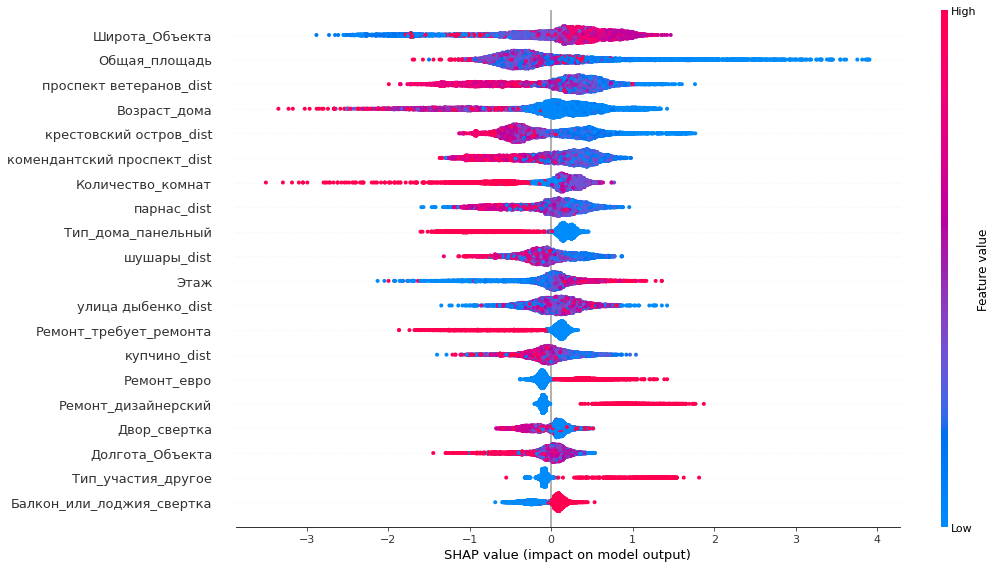

In [ ]:
shap_plot(cv_cl[1][3], train_cl[X_cl])

## Regressor

In [ ]:
X_reg = X_cl + ['y_cl_pred']

pool_train_reg = Pool(
    train_reg[X_reg], 
    train_reg[y],
    )

pool_test = Pool(
    test_ohe[X_reg], 
    test_ohe[y],
    )

In [ ]:
%%time

params = {
    "learning_rate": 0.8,
    "eval_metric": "MAPE",
    "loss_function": "MAPE",
    "random_seed": SEED,
    "early_stopping_rounds": 200,
}

cv_reg = cv(
    pool=pool_train_reg,
    params=params,
    fold_count=5,
    shuffle=True,
    verbose=250,
    return_models=True,
)

Training on fold [0/5]
0:	learn: 0.2791144	test: 0.2808947	best: 0.2808947 (0)	total: 5.99ms	remaining: 5.98s
250:	learn: 0.2177694	test: 0.2298715	best: 0.2298631 (245)	total: 1.48s	remaining: 4.42s
500:	learn: 0.2128950	test: 0.2278363	best: 0.2278211 (499)	total: 2.94s	remaining: 2.92s
750:	learn: 0.2114653	test: 0.2275060	best: 0.2274210 (553)	total: 4.38s	remaining: 1.45s

bestTest = 0.2274209656
bestIteration = 553

Training on fold [1/5]
0:	learn: 0.2790400	test: 0.2834930	best: 0.2834930 (0)	total: 5.63ms	remaining: 5.62s
250:	learn: 0.2054976	test: 0.2308025	best: 0.2307490 (240)	total: 1.4s	remaining: 4.17s
500:	learn: 0.1915434	test: 0.2204647	best: 0.2204647 (500)	total: 2.81s	remaining: 2.79s
750:	learn: 0.1873841	test: 0.2188463	best: 0.2187261 (734)	total: 4.21s	remaining: 1.4s
999:	learn: 0.1855438	test: 0.2182566	best: 0.2182501 (942)	total: 5.67s	remaining: 0us

bestTest = 0.2182500643
bestIteration = 942

Training on fold [2/5]
0:	learn: 0.2642113	test: 0.2687566	bes

In [ ]:
cv_reg[0]['test-MAPE-mean'].min(), cv_reg[0]['test-MAPE-std'].min()

(0.21753654513247503, 0.009101522078840907)

(0.18906280534550665, 0.00122380895804591)

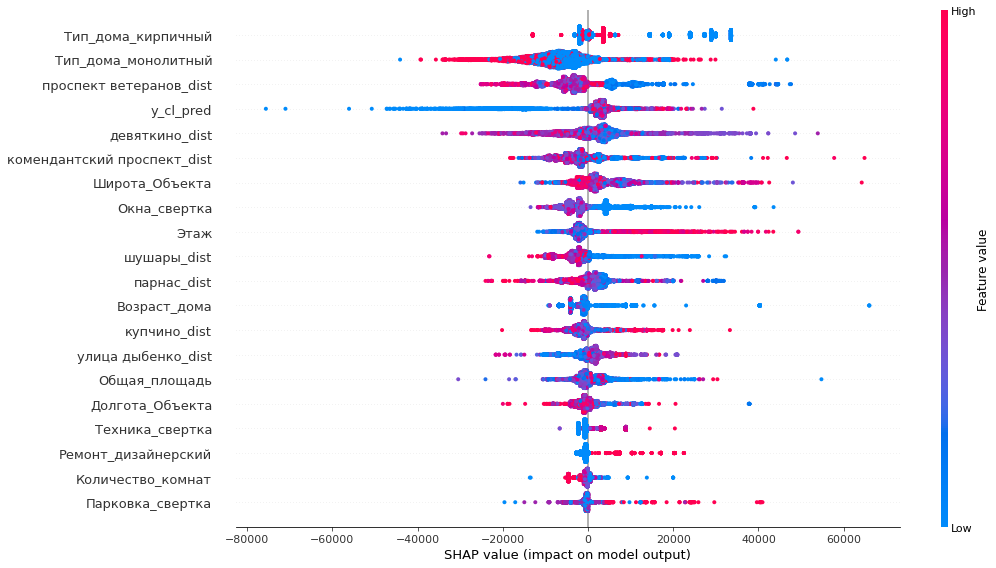

In [ ]:
shap_plot(cv_reg[1][4], train_reg[X_reg])

# Optuna

## Classifier

In [ ]:
def objective_cb_cl(trial):

    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1),
        'custom_loss':['Accuracy'],
        "loss_function": "MultiClass",
        "random_seed": SEED,
        "early_stopping_rounds": 200,
        "depth": trial.suggest_int("depth", 3, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 10),
        "used_ram_limit": "8gb",
        "auto_class_weights": "Balanced",        
    }

    cv_cl = cv(
        pool=pool_train_cl,
        params=params,
        fold_count=5,
        shuffle=True,
        verbose=False,
        return_models=True,
    )
    
    return cv_cl[0]['test-MultiClass-mean'].min()

In [ ]:
%%time
study_cb_cl = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=SEED))
study_cb_cl.optimize(objective_cb_cl, n_trials=10, show_progress_bar=True)

[I 2022-12-21 04:25:05,024] A new study created in memory with name: no-name-a7e6f01b-3f59-43db-96a6-f75bd741a58a
Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Training on fold [0/5]

bestTest = 1.356638519
bestIteration = 110

Training on fold [1/5]

bestTest = 1.234995607
bestIteration = 136

Training on fold [2/5]

bestTest = 1.304375144
bestIteration = 138

Training on fold [3/5]

bestTest = 1.29894807
bestIteration = 138

Training on fold [4/5]

bestTest = 1.261067706
bestIteration = 193

[I 2022-12-21 04:26:26,928] Trial 0 finished with value: 1.293516642409822 and parameters: {'learning_rate': 0.3148556030987211, 'depth': 7, 'min_data_in_leaf': 8}. Best is trial 0 with value: 1.293516642409822.
Training on fold [0/5]

bestTest = 1.464135802
bestIteration = 13

Training on fold [1/5]

bestTest = 1.332638171
bestIteration = 23

Training on fold [2/5]

bestTest = 1.433297188
bestIteration = 21

Training on fold [3/5]

bestTest = 1.410440019
bestIteration = 28

Training on fold [4/5]

bestTest = 1.394766015
bestIteration = 32

[I 2022-12-21 04:29:00,196] Trial 1 finished with value: 1.4112931434973934 and parameters: {'learning_rate': 0.79

[I 2022-12-02 06:11:47,501] Trial 15 finished with value: 0.6501964804063316 and parameters: {'learning_rate': 0.10932252319603704, 'depth': 5, 'min_data_in_leaf': 10}. Best is trial 15 with value: 0.6501964804063316.

Trial 0 finished with value: 0.6405056302365976 and parameters: {'learning_rate': 0.3148556030987211, 'depth': 7, 'min_data_in_leaf': 8}. Best is trial 0 with value: 0.6405056302365976.

In [ ]:
params_cl_best = {
    'custom_loss':['Accuracy'],
    "loss_function": "MultiClass",
    "random_seed": SEED,
    "early_stopping_rounds": 200,
    "used_ram_limit": "8gb",
    'verbose':250,
    "auto_class_weights": "Balanced",    
    **study_cb_cl.best_params
}

cb_cl_best = CatBoostClassifier(**params_cl_best)
cb_cl_best.fit(pool_train_cl)

0:	learn: 1.8718260	total: 21.6ms	remaining: 21.5s
250:	learn: 1.0809673	total: 3.14s	remaining: 9.37s
500:	learn: 0.9047508	total: 6.27s	remaining: 6.25s
750:	learn: 0.7885344	total: 9.5s	remaining: 3.15s
999:	learn: 0.6969076	total: 12.7s	remaining: 0us


In [ ]:
train_cl['y_cl_pred'] = cb_cl_best.predict(train_cl[X_cl])
train_reg['y_cl_pred'] = cb_cl_best.predict(train_reg[X_cl])

In [ ]:
print(classification_report(train_reg[y_cl], train_reg['y_cl_pred']))

              precision    recall  f1-score   support

           0       0.67      0.69      0.68      1182
           1       0.49      0.45      0.47      1275
           2       0.43      0.39      0.41      1392
           3       0.34      0.34      0.34      1015
           4       0.37      0.40      0.39       808
           5       0.50      0.51      0.51       998
           6       0.67      0.76      0.71       858

    accuracy                           0.50      7528
   macro avg       0.50      0.51      0.50      7528
weighted avg       0.50      0.50      0.50      7528



## Regressor

In [ ]:
def objective_cb_reg(trial):

    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 1),
        "eval_metric": "MAPE",
        "loss_function": "MAPE",
        "random_seed": SEED,
        "early_stopping_rounds": 200,
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 10),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "8gb",
    }

    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cv_optuna = cv(
            pool=pool_train_reg,
            params=params,
            fold_count=5,
            shuffle=True,
            verbose=False,
            return_models=True,
            )
    
    return cv_optuna[0]['test-MAPE-mean'].min()

In [ ]:
%%time
study_cb = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=SEED))
study_cb.optimize(objective_cb_reg, n_trials=10, show_progress_bar=True)

[I 2022-12-21 04:48:32,970] A new study created in memory with name: no-name-0b85a34b-1e23-4dd6-83a7-f4261d823f49
Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Training on fold [0/5]

bestTest = 0.1787464119
bestIteration = 523

Training on fold [1/5]

bestTest = 0.1735082707
bestIteration = 792

Training on fold [2/5]

bestTest = 0.18703443
bestIteration = 962

Training on fold [3/5]

bestTest = 0.1783103538
bestIteration = 888

Training on fold [4/5]

bestTest = 0.1732594179
bestIteration = 451

[I 2022-12-21 04:50:02,800] Trial 0 finished with value: 0.17872365892217001 and parameters: {'learning_rate': 0.37714145736247373, 'min_data_in_leaf': 6, 'colsample_bylevel': 0.07914678953841761, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.17872365892217001.
Training on fold [0/5]

bestTest = 0.2633449004
bestIteration = 996

Training on fold [1/5]

bestTest = 0.2715468741
bestIteration = 988

Training on fold [2/5]

bestTest = 0.2610006565
bestIteration = 998

Training on fold [3/5]

bestTest = 0.2635356288
bestIteration = 914

Training on fold [4/5]

bestTest = 0.2458553757
bestIteration = 999


[I 2022-11-30 23:32:17,726] Trial 7 finished with value: 0.1551172357942032 and parameters: {'learning_rate': 0.19737577875235096, 'colsample_bylevel': 0.06694527030323656, 'depth': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.42824768280280123}. Best is trial 7 with value: 0.1551172357942032.

[I 2022-12-02 18:06:10,512] Trial 13 finished with value: 0.15849452889398355 and parameters: {'learning_rate': 0.9908769302286312, 'depth': 10, 'min_data_in_leaf': 4, 'colsample_bylevel': 0.06661378366252292, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.15849452889398355.

# Test

In [ ]:
test_ohe['y_cl_pred'] = cb_cl_best.predict(test_ohe[X_cl])

In [ ]:
params_reg = {
        "eval_metric": "MAPE",
        "loss_function": "MAPE",
        "random_seed": SEED,
        "early_stopping_rounds": 200,
        "used_ram_limit": "8gb",
        **study_cb.best_params
    }

cb_reg = CatBoostRegressor(**params_reg, verbose=250)

In [ ]:
cb_reg.fit(pool_train_reg)

0:	learn: 0.2190827	total: 10.1ms	remaining: 10.1s
250:	learn: 0.0631400	total: 1.85s	remaining: 5.53s
500:	learn: 0.0462308	total: 3.63s	remaining: 3.61s
750:	learn: 0.0367218	total: 5.46s	remaining: 1.81s
999:	learn: 0.0314550	total: 7.32s	remaining: 0us


In [ ]:
test_ohe['y_reg_pred'] = cb_reg.predict(test_ohe[X_reg])

In [ ]:
mean_absolute_percentage_error(test_ohe[y], test_ohe['y_reg_pred'])

0.16117986455654182

In [ ]:
test_ohe[['Цена_кв_м', 'y_reg_pred']]

,Цена_кв_м,y_reg_pred
1551,134000.000000,132192.930237
16089,168134.715026,183448.530394
8475,298870.000000,279497.975716
8921,143661.971831,238654.447707
630,180894.308943,169817.611393
...,...,...
6792,166071.428571,198181.692999
9601,271428.571429,284771.790249
1268,255746.660584,253831.562888
15349,153081.491054,184285.265491


# Feature optimizer

In [ ]:
age_categories = [
    -float('inf'),
    0, 
    5, 
    10, 
    20, 
    40, 
    float('inf')
    ]

age_categories_labels = [0, 1, 2, 3, 4, 5]

df['Возраст_дома_кат'] = pd.cut(df['Возраст_дома'], age_categories, labels=age_categories_labels)

df.groupby(by='Возраст_дома_кат')['Общая_площадь'].agg({'count', 'mean'})

In [331]:
key_features = [
    #'Цена',
    'Количество_комнат',
    'Общая_площадь',
    'Этаж',
    #'Тип_дома',
    'Широта_Объекта',
    'Долгота_Объекта',
    'комендантский проспект_dist',
    'крестовский остров_dist',
    'шушары_dist',
    'парнас_dist',
    'купчино_dist',
    'улица дыбенко_dist',
    'девяткино_dist',
    'проспект ветеранов_dist',
    'Цена_кв_м',
    #'Цена_кв_м_кат',
    'Балкон_или_лоджия_свертка',
    #'Вид_сделки_свертка',
    #'В_доме_свертка',
    #'Двор_свертка',
    #'Мебель_свертка',
    #'Окна_свертка',
    #'Парковка_свертка',
    #'Санузел_свертка',
    #'Техника_свертка',
    #'Тип_комнат_свертка',
    'Возраст_дома',
    'Грузовой_лифт_no_info',
    'Пассажирский_лифт_no_info',
    ]

In [332]:
df_feature_opt = df[key_features]
df_feature_opt.columns = [
    #'cost',
    'rooms',
    'total_area',
    'stage',
    #'building_type',
    'latitude',
    'longitude',
    'komendatskiy_prospekt_dist',
    'krestovskiy_ostrov_dist',
    'shushary_dist',
    'parnas_dist',
    'kupchino_dist',
    'ulitsa_dybenko_dist',
    'devyatkino_dist',
    'prospekt_veteranov_dist',
    'cost_m_2',
    #'Цена_кв_м_кат',
    'balcony',
    #'deal_type',
    #'into_building',
    #'yard',
    #'furniture',
    #'windows',
    #'parking',
    #'wc',
    #'devices',
    #'rooms_type',
    'building_age',
    'largage_elevator',
    'elevator',
]

y = ['cost_m_2']

cat_features_opt = [
#    'building_age',
#    'deal_type',
#    'building_type', 
#    'yard',
#    'furniture',
#    'windows',
#    'parking',
#    'devices',
#    'rooms_type',
    ]

#df_feature_opt['building_type'] = df_feature_opt['building_type'].replace(
#    {'деревянный': 'wood',
#     'кирпичный': 'brick',
#     'монолитно-кирпичный': 'monolithic-brick',
#     'монолитный': 'monolithic',
#     'панельный': 'panel'
#     }
#)

In [333]:
train_opt, test_opt = train_test_split(df_feature_opt, test_size=.2, random_state=SEED)

#train_opt, test_opt = ohe(train_opt, test_opt, cat_features_opt)

In [334]:
X_opt = train_opt.drop(y, axis=1).columns.tolist()

In [335]:
test_opt[X_opt]

,rooms,total_area,stage,latitude,longitude,komendatskiy_prospekt_dist,krestovskiy_ostrov_dist,shushary_dist,parnas_dist,kupchino_dist,ulitsa_dybenko_dist,devyatkino_dist,prospekt_veteranov_dist,balcony,building_age,largage_elevator,elevator
1551,2,63.5,3,59.808559,30.079387,29.851,27.010,39.286,40.304,33.014,46.213,48.521,19.387,1,-1,1,1
16089,0,19.3,4,59.922571,30.338290,13.026,10.332,15.496,16.057,11.118,16.204,18.348,13.227,0,0,1,1
8475,2,61.9,2,59.987375,30.311412,6.318,6.029,22.974,9.192,18.915,21.069,16.208,17.501,0,-2,1,1
8921,3,71.0,6,59.907627,30.322947,13.301,10.035,15.611,17.751,10.450,17.821,20.715,10.848,0,110,0,0
630,0,24.6,4,59.838937,30.104297,25.490,22.701,36.558,35.958,30.178,42.802,44.365,16.261,1,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6792,2,56.0,4,59.848832,30.102689,24.812,22.141,36.816,35.322,30.414,42.797,43.947,16.453,1,4,1,0
9601,2,56.0,12,59.985070,30.326289,7.957,7.574,21.829,9.142,18.110,19.467,14.856,17.977,1,0,0,0
1268,2,54.8,12,59.947176,29.965049,33.335,32.830,53.860,43.092,47.464,57.764,54.339,33.812,0,0,1,1
15349,2,50.3,7,59.985003,30.415824,17.661,17.441,18.436,12.885,17.817,11.428,7.850,24.277,1,56,1,0


In [336]:
pool_train_opt = Pool(
    train_opt[X_opt], 
    train_opt[y],
    )
pool_test_opt = Pool(
    test_opt[X_opt], 
    test_opt[y],
    )

## Regressor

In [282]:
def objective_cb_opt(trial):

    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 1),
        "eval_metric": "MAPE",
        "loss_function": "MAPE",
        "random_seed": SEED,
        "early_stopping_rounds": 200,
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 10),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "8gb",
    }

    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cv_optuna = cv(
            pool=pool_train_opt,
            params=params,
            fold_count=5,
            shuffle=True,
            verbose=False,
            return_models=True,
            )
    
    return cv_optuna[0]['test-MAPE-mean'].min()

In [302]:
%%time
study_cb_opt = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=SEED))
study_cb_opt.optimize(objective_cb_opt, n_trials=20, show_progress_bar=True)

[I 2022-12-31 08:22:51,040] A new study created in memory with name: no-name-d20e9b1a-8dd0-46a6-9413-a659824dfa4b
Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/20 [00:00<?, ?it/s]

Training on fold [0/5]

bestTest = 0.2372644141
bestIteration = 996

Training on fold [1/5]

bestTest = 0.2304620059
bestIteration = 999

Training on fold [2/5]

bestTest = 0.2528677318
bestIteration = 998

Training on fold [3/5]

bestTest = 0.2366220563
bestIteration = 978

Training on fold [4/5]

bestTest = 0.2467825698
bestIteration = 999

[I 2022-12-31 08:23:25,752] Trial 0 finished with value: 0.24080229058399313 and parameters: {'learning_rate': 0.37714145736247373, 'min_data_in_leaf': 6, 'colsample_bylevel': 0.07914678953841761, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.24080229058399313.
Training on fold [0/5]

bestTest = 0.2924529951
bestIteration = 999

Training on fold [1/5]

bestTest = 0.2954374032
bestIteration = 998

Training on fold [2/5]

bestTest = 0.304753304
bestIteration = 994

Training on fold [3/5]

bestTest = 0.3041099014
bestIteration = 999

Training on fold [4/5]

bestTest = 0.3128540367
bestIteration = 998

## Test

In [309]:
#best_params = study_cb_opt.best_params
best_params = {'learning_rate': 0.669937374425716, 'min_data_in_leaf': 4, 'colsample_bylevel': 0.09781525853636924, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.401737432094735}

In [310]:
params_opt = {
        "eval_metric": "MAPE",
        "loss_function": "MAPE",
        "random_seed": SEED,
        "early_stopping_rounds": 200,
        "used_ram_limit": "8gb",
        **best_params
    }

cb_opt = CatBoostRegressor(**params_opt, verbose=250)

In [337]:
cb_opt.fit(pool_train_opt)

0:	learn: 0.2281504	total: 1.87ms	remaining: 1.87s
250:	learn: 0.1640815	total: 788ms	remaining: 2.35s
500:	learn: 0.1475272	total: 1.61s	remaining: 1.61s
750:	learn: 0.1404271	total: 2.4s	remaining: 796ms
999:	learn: 0.1343855	total: 3.24s	remaining: 0us


In [338]:
test_opt['y_pred'] = cb_opt.predict(test_opt[X_opt])

In [339]:
mean_absolute_percentage_error(test_opt[y], test_opt['y_pred'])

0.16398272865148558

In [340]:
feature_important = pd.DataFrame(
    cb_opt.feature_importances_, 
    cb_opt.feature_names_,
    columns=['value']).sort_values(by='value', ascending=False)

feature_important

,value
building_age,14.056794
total_area,8.384693
rooms,6.940818
balcony,6.383190
stage,6.069159
devyatkino_dist,5.593378
kupchino_dist,5.420296
longitude,5.329563
ulitsa_dybenko_dist,5.246722
shushary_dist,5.222510


In [341]:
cb_opt.save_model('catboost_model.json')
cb_opt.save_model('catboost_model.cbm')